# SABIC closing price prediction

### Group names:
- Abdullah Alothman
- Amani Almarzoog
- Atheer Alhejaily
- Fatimah Al-Rashed


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import Line
import plotly.express as px
# !pip install chart_studio
import chart_studio.plotly as py
import chart_studio
import warnings
warnings.filterwarnings('ignore')
plt.style.use("seaborn")

from pandas.plotting import lag_plot
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import figure
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error 
# !pip install pystan==2.19.1.1 prophet
from prophet import Prophet

# Information about the data

We have three data sets:
* First from Sabic (close, open, high and low) 
* Second from Tasi index (close and volume)
* Third from Parallel market index (close and volume)


# Sabic

Ranked among the world's largest petrochemicals manufacturers, SABIC is a public company based in Riyadh, Saudi Arabia. 70% of the Company's shares are owned by Saudi Aramco, with the remaining 30% publicly traded on the Saudi stock exchange.

# Tasi 

The Saudi Stock Exchange (Tadawul) is a joint stock company and the sole entity authorized in the Kingdom to act as the Securities Exchange (the “Exchange”), carrying out listing and trading in securities

# Parallel Market

A parallel equity market with lighter listing requirements that serves as an alternative platform for companies to go public, and the investment in this market is restricted to Qualified Investors.

MAIN CHARACTERISTICS:

* Market with lighter requirements.
* Restricted to Qualified Investors.
* Possibility of transition to Main Market after obtaining needed approvals.

In [2]:
# loading data set
df1 = pd.read_csv("./DataSet/2010 Historical Data.csv")
df2 = pd.read_csv("./DataSet/Tadawul All Share Historical Data.csv")
df3 = pd.read_csv("./DataSet/NOMU Parallel Market Capped Historical Data.csv")

In [3]:
# joining data sets
df = pd.merge(pd.merge(df1, df2, on="Date"), df3, on="Date", how="left")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 0 to 1103
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1104 non-null   object 
 1   Price_x     1104 non-null   float64
 2   Open_x      1104 non-null   float64
 3   High_x      1104 non-null   float64
 4   Low_x       1104 non-null   float64
 5   Vol._x      1104 non-null   object 
 6   Change %_x  1104 non-null   object 
 7   Price_y     1104 non-null   object 
 8   Open_y      1104 non-null   object 
 9   High_y      1104 non-null   object 
 10  Low_y       1104 non-null   object 
 11  Vol._y      1104 non-null   object 
 12  Change %_y  1104 non-null   object 
 13  Price       1063 non-null   object 
 14  Open        1063 non-null   object 
 15  High        1063 non-null   object 
 16  Low         1063 non-null   object 
 17  Vol.        1063 non-null   object 
 18  Change %    1063 non-null   object 
dtypes: float64(4), object(15)
m

In [5]:
# labeling columns

df.rename(columns={"Price_x": "Close_Sabic",
                   "Open_x": "Open_Sabic",
                   "High_x":"High_Sabic",
                   "Low_x":"Low_Sabic",
                   "Vol._x":"Vol_Sabic",
                   "Change %_x":"Change%_Sabic",
                   "Price_y":"Close_Tasi",
                   "Open_y": "Open_Tasi",
                   "High_y":"High_Tasi",
                   "Low_y":"Low_Tasi",
                   "Vol._y":"Vol_Tasi",
                   "Change %_y":"Change%_Tasi",
                   "Price":"Close_Nomu",
                   "Open": "Open_Nomu",
                   "High":"High_Nomu",
                   "Low":"Low_Nomu",
                   "Vol.":"Vol_Nomu",
                   "Change %":"Change%_Nomu"}, inplace = True)
df.head(5)

,Date,Close_Sabic,Open_Sabic,High_Sabic,Low_Sabic,Vol_Sabic,Change%_Sabic,Close_Tasi,Open_Tasi,High_Tasi,Low_Tasi,Vol_Tasi,Change%_Tasi,Close_Nomu,Open_Nomu,High_Nomu,Low_Nomu,Vol_Nomu,Change%_Nomu
0,"Jun 01, 2021",124.0,124.2,124.8,123.6,1.03M,-0.16%,"10,597.42","10,560.85","10,644.34","10,552.67",499.94M,0.44%,"23,925.19","23,588.59","24,032.07","23,342.43",642.59K,1.72%
1,"May 31, 2021",124.2,124.0,124.2,123.2,1.15M,0.49%,"10,551.23","10,561.46","10,569.50","10,514.97",464.24M,0.03%,"23,519.96","23,866.75","23,947.25","23,440.51",594.53K,-1.44%
2,"May 30, 2021",123.6,124.2,124.8,123.2,1.10M,-0.48%,"10,547.67","10,529.76","10,571.98","10,519.24",408.59M,0.27%,"23,863.69","23,770.46","23,910.12","23,757.46",483.51K,0.89%
3,"May 27, 2021",124.2,122.2,124.2,122.2,3.02M,1.64%,"10,519.52","10,472.41","10,519.52","10,461.53",382.97M,0.46%,"23,653.59","23,743.71","24,038.46","23,617.81",1.02M,-0.32%
4,"May 26, 2021",122.2,121.6,123.0,121.6,762.31K,0.66%,"10,471.55","10,452.61","10,490.16","10,447.57",302.15M,0.23%,"23,730.43","23,921.45","24,338.79","23,646.25",606.71K,-2.21%


# Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 0 to 1103
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1104 non-null   object 
 1   Close_Sabic    1104 non-null   float64
 2   Open_Sabic     1104 non-null   float64
 3   High_Sabic     1104 non-null   float64
 4   Low_Sabic      1104 non-null   float64
 5   Vol_Sabic      1104 non-null   object 
 6   Change%_Sabic  1104 non-null   object 
 7   Close_Tasi     1104 non-null   object 
 8   Open_Tasi      1104 non-null   object 
 9   High_Tasi      1104 non-null   object 
 10  Low_Tasi       1104 non-null   object 
 11  Vol_Tasi       1104 non-null   object 
 12  Change%_Tasi   1104 non-null   object 
 13  Close_Nomu     1063 non-null   object 
 14  Open_Nomu      1063 non-null   object 
 15  High_Nomu      1063 non-null   object 
 16  Low_Nomu       1063 non-null   object 
 17  Vol_Nomu       1063 non-null   object 
 18  Change%_

In [7]:
# fliping the data set so it starts from 2017 and ends in 2021
df = df[::-1].reset_index(drop=True)

In [8]:
# replaceing K-M-B 
df["Vol_Sabic"] = df["Vol_Sabic"].replace({"K":"*1e3", "M":"*1e6","B":"*1e9"}, regex=True).map(pd.eval).astype(int)
df["Vol_Tasi"] = df["Vol_Tasi"].replace({"K":"*1e3", "M":"*1e6","B":"*1e9"}, regex=True).map(pd.eval).astype(int)
df["Vol_Nomu"] = df["Vol_Nomu"].dropna().replace({"K":"*1e3", "M":"*1e6","B":"*1e9"}, regex=True).map(pd.eval).astype(int)

In [9]:
# Change Date type and split it to Year and month and day. 
df['Date'] = df['Date'].apply(pd.to_datetime)
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day

In [10]:
# Select object columns 
obj = df.select_dtypes(include=['object'])
obj

,Change%_Sabic,Close_Tasi,Open_Tasi,High_Tasi,Low_Tasi,Change%_Tasi,Close_Nomu,Open_Nomu,High_Nomu,Low_Nomu,Change%_Nomu
0,0.00%,"7,237.95","7,210.43","7,250.19","7,207.65",0.38%,NaN,NaN,NaN,NaN,NaN
1,0.27%,"7,247.34","7,237.95","7,290.33","7,224.77",0.13%,NaN,NaN,NaN,NaN,NaN
2,0.82%,"7,250.76","7,247.34","7,260.37","7,209.51",0.05%,NaN,NaN,NaN,NaN,NaN
3,-0.54%,"7,198.11","7,250.76","7,254.61","7,182.79",-0.73%,NaN,NaN,NaN,NaN,NaN
4,0.54%,"7,198.73","7,198.11","7,224.50","7,176.32",0.01%,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1099,0.66%,"10,471.55","10,452.61","10,490.16","10,447.57",0.23%,"23,730.43","23,921.45","24,338.79","23,646.25",-2.21%
1100,1.64%,"10,519.52","10,472.41","10,519.52","10,461.53",0.46%,"23,653.59","23,743.71","24,038.46","23,617.81",-0.32%
1101,-0.48%,"10,547.67","10,529.76","10,571.98","10,519.24",0.27%,"23,863.69","23,770.46","23,910.12","23,757.46",0.89%
1102,0.49%,"10,551.23","10,561.46","10,569.50","10,514.97",0.03%,"23,519.96","23,866.75","23,947.25","23,440.51",-1.44%


In [11]:
# replaceing , and % and change the types to float.  
df[obj.columns] = obj.replace({",":"","%":""}, regex=True).astype(float)

In [12]:
df.tail(5)

,Date,Close_Sabic,Open_Sabic,High_Sabic,Low_Sabic,Vol_Sabic,Change%_Sabic,Close_Tasi,Open_Tasi,High_Tasi,...,Change%_Tasi,Close_Nomu,Open_Nomu,High_Nomu,Low_Nomu,Vol_Nomu,Change%_Nomu,Year,Month,Day
1099,2021-05-26,122.2,121.6,123.0,121.6,762310,0.66,10471.55,10452.61,10490.16,...,0.23,23730.43,23921.45,24338.79,23646.25,606710.0,-2.21,2021,5,26
1100,2021-05-27,124.2,122.2,124.2,122.2,3020000,1.64,10519.52,10472.41,10519.52,...,0.46,23653.59,23743.71,24038.46,23617.81,1020000.0,-0.32,2021,5,27
1101,2021-05-30,123.6,124.2,124.8,123.2,1100000,-0.48,10547.67,10529.76,10571.98,...,0.27,23863.69,23770.46,23910.12,23757.46,483510.0,0.89,2021,5,30
1102,2021-05-31,124.2,124.0,124.2,123.2,1150000,0.49,10551.23,10561.46,10569.50,...,0.03,23519.96,23866.75,23947.25,23440.51,594530.0,-1.44,2021,5,31
1103,2021-06-01,124.0,124.2,124.8,123.6,1030000,-0.16,10597.42,10560.85,10644.34,...,0.44,23925.19,23588.59,24032.07,23342.43,642590.0,1.72,2021,6,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1104 non-null   datetime64[ns]
 1   Close_Sabic    1104 non-null   float64       
 2   Open_Sabic     1104 non-null   float64       
 3   High_Sabic     1104 non-null   float64       
 4   Low_Sabic      1104 non-null   float64       
 5   Vol_Sabic      1104 non-null   int64         
 6   Change%_Sabic  1104 non-null   float64       
 7   Close_Tasi     1104 non-null   float64       
 8   Open_Tasi      1104 non-null   float64       
 9   High_Tasi      1104 non-null   float64       
 10  Low_Tasi       1104 non-null   float64       
 11  Vol_Tasi       1104 non-null   int64         
 12  Change%_Tasi   1104 non-null   float64       
 13  Close_Nomu     1063 non-null   float64       
 14  Open_Nomu      1063 non-null   float64       
 15  High_Nomu      1063 n

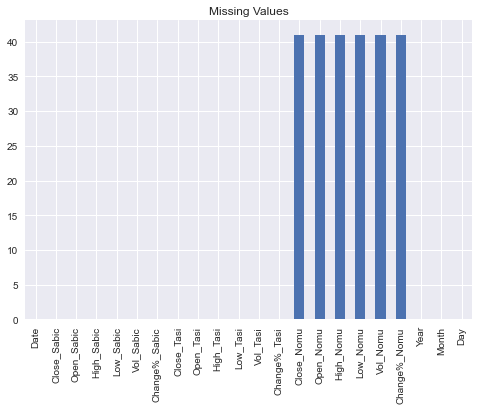

In [14]:
# Detect missing values.
df.isnull().sum().plot(kind="bar", title="Missing Values");

In [15]:
# Outliner (wrong input) discovered in EDA
df.max()
# 2,100,000,000 (Sabic Vol) > 782,260,000 (Market Vol)

Date             2021-06-01 00:00:00
Close_Sabic                    130.4
Open_Sabic                     130.6
High_Sabic                     131.4
Low_Sabic                      129.2
Vol_Sabic                 2100000000
Change%_Sabic                   8.42
Close_Tasi                   10597.4
Open_Tasi                    10561.5
High_Tasi                    10644.3
Low_Tasi                     10552.7
Vol_Tasi                  2350000000
Change%_Tasi                    7.07
Close_Nomu                   27866.7
Open_Nomu                    27866.7
High_Nomu                    28103.1
Low_Nomu                     27066.1
Vol_Nomu                    6.42e+06
Change%_Nomu                   17.18
Year                            2021
Month                             12
Day                               31
dtype: object

In [16]:
df.drop(df[df["Vol_Sabic"]==2100000000].index, inplace = True)

In [17]:
# Dealing with missing data

df = df.dropna()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1062 entries, 41 to 1103
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1062 non-null   datetime64[ns]
 1   Close_Sabic    1062 non-null   float64       
 2   Open_Sabic     1062 non-null   float64       
 3   High_Sabic     1062 non-null   float64       
 4   Low_Sabic      1062 non-null   float64       
 5   Vol_Sabic      1062 non-null   int64         
 6   Change%_Sabic  1062 non-null   float64       
 7   Close_Tasi     1062 non-null   float64       
 8   Open_Tasi      1062 non-null   float64       
 9   High_Tasi      1062 non-null   float64       
 10  Low_Tasi       1062 non-null   float64       
 11  Vol_Tasi       1062 non-null   int64         
 12  Change%_Tasi   1062 non-null   float64       
 13  Close_Nomu     1062 non-null   float64       
 14  Open_Nomu      1062 non-null   float64       
 15  High_Nomu      1062 

# Data Split

In [19]:
# Spliting the data into: training (70%) and testing (30%)
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]

In [20]:
print("Training data points:",len(train_data),"\nTesting data points:",len(test_data))

Training data points: 743 
Testing data points: 319


# EDA

## 1. Sabic performance over years

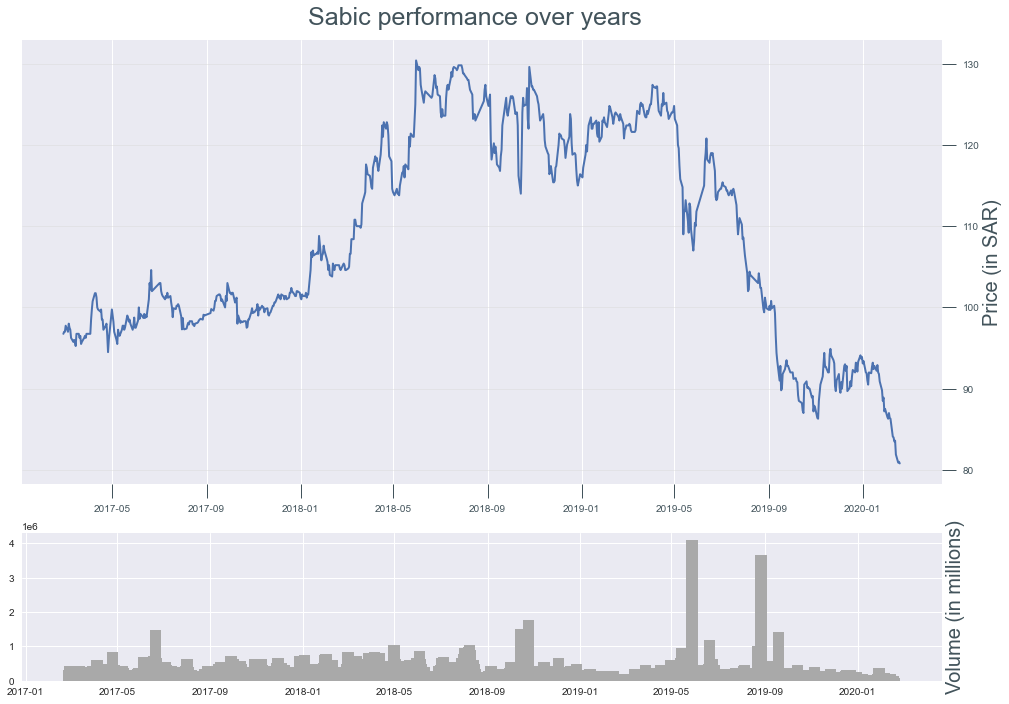

In [100]:
colors = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 14, 'color': colors['grey'], 'labelcolor': colors['grey']}

plt.rc('figure', figsize=(14, 10))
fig, axes = plt.subplots(2, 1, 
            gridspec_kw={'height_ratios': [3, 1]})
fig.tight_layout(pad=3)

date = train_data['Date']
close = train_data['Close_Sabic']
vol = train_data['Vol_Sabic']

plot_price = axes[0]
plot_price.plot(date, close, linewidth=2, label='Price')

plot_vol = axes[1]
plot_vol.bar(date, vol/10, width=15, color='darkgrey')
plot_vol.set_ylabel('Volume (in millions)', fontsize=20)
plot_vol.yaxis.set_label_position("right")
plot_vol.yaxis.label.set_color(colors['grey'])


plot_price.yaxis.tick_right()
plot_price.tick_params(axis='both', **config_ticks)
plot_price.set_ylabel('Price (in SAR)', fontsize=20)
plot_price.yaxis.set_label_position("right")
plot_price.yaxis.label.set_color(colors['grey'])
plot_price.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
plot_price.set_axisbelow(True)
fig.suptitle('Sabic performance over years', size=25, color=colors['grey'] , y=1);
# plt.savefig('Sabic performance over years.png', bbox_inches="tight")

## 2. The volume for Sabic and Nomu over years

In [92]:
# username = 'Atheera' # Add your username
# api_key = '*******' # Add your api key 
# chart_studio.tools.set_credentials_file(username = username, api_key = api_key)

In [22]:
# Calculate the volume for Sabic and Tasi and Nomu per year. 
df3 = df.groupby("Year").sum()[['Vol_Sabic',"Vol_Nomu"]].reset_index()
df3


,Year,Vol_Sabic,Vol_Nomu
0,2017,770159992,53309800.0
1,2018,1104058284,22860926.0
2,2019,739175489,78562767.0
3,2020,480422537,119044330.0
4,2021,153058530,40848829.0


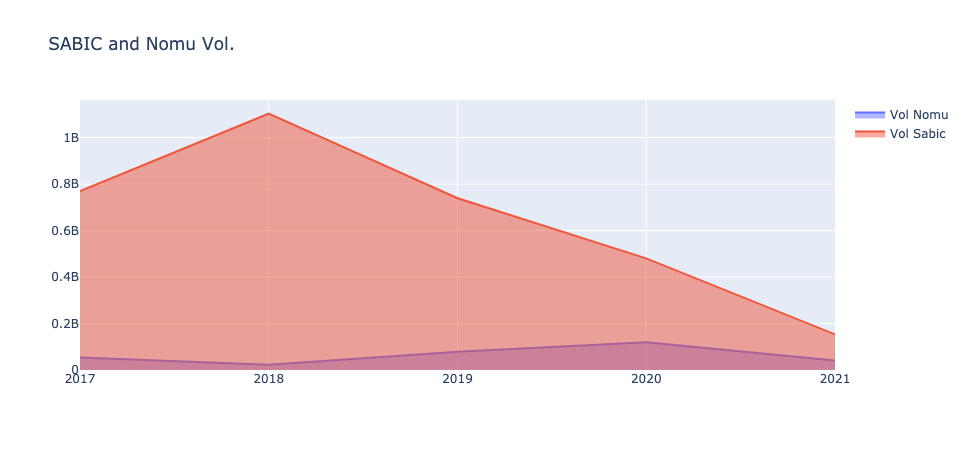

In [90]:
#SABIC and Nomu Vol
fig = go.Figure()
fig.add_trace(Line(x=df3.Year,y=df3.Vol_Nomu,
                    mode='lines', fill='tozeroy',
                        name = "Vol Nomu"))
fig.add_trace(Line(x=df3.Year,y=df3.Vol_Sabic,
                    mode='lines', fill='tozeroy',
                        name = "Vol Sabic"))
fig.update_layout(title_text="SABIC and Nomu Vol.")
fig.update_xaxes(
    dtick="M1",
    tickformat="Y")

In [93]:
# py.plot(fig, filename = 'SABIC and Nomu', auto_open=True)

'https://plotly.com/~Atheera/1/'

## 3. Close Value for Tasi and Nomu 

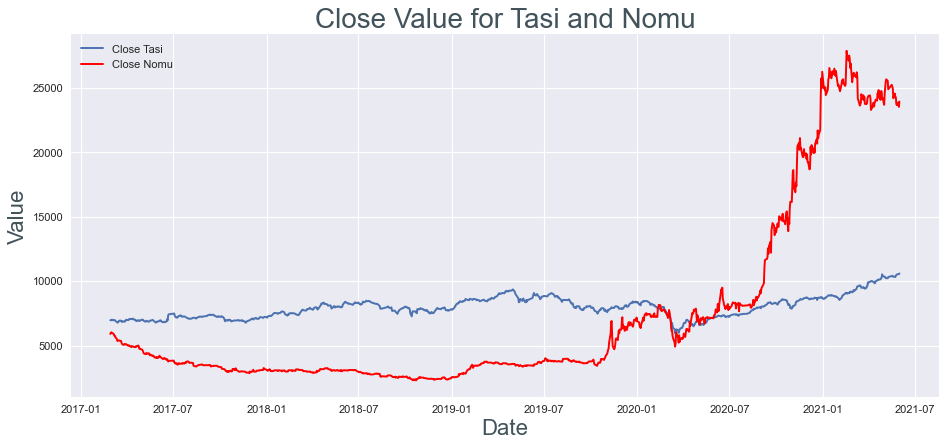

In [102]:
#Close Value for Tasi and Nomu
plt.figure(figsize=(14,6), dpi=80)
sns.lineplot(data=df, x="Date", y=df.Close_Tasi, label="Close Tasi")
sns.lineplot(data=df, x="Date", y=df.Close_Nomu,color='red', label="Close Nomu")
plt.title("Close Value for Tasi and Nomu",size=25, color=colors['grey'] )
plt.xlabel("Date",color=colors['grey'],size=20)
plt.ylabel("Value",color=colors['grey'],size=20)
plt.legend()
# plt.savefig('Close Value for Tasi and Nomu.png')
plt.show()

## 4. The correlation between Tasi and Nomu using pairplot & heatmap

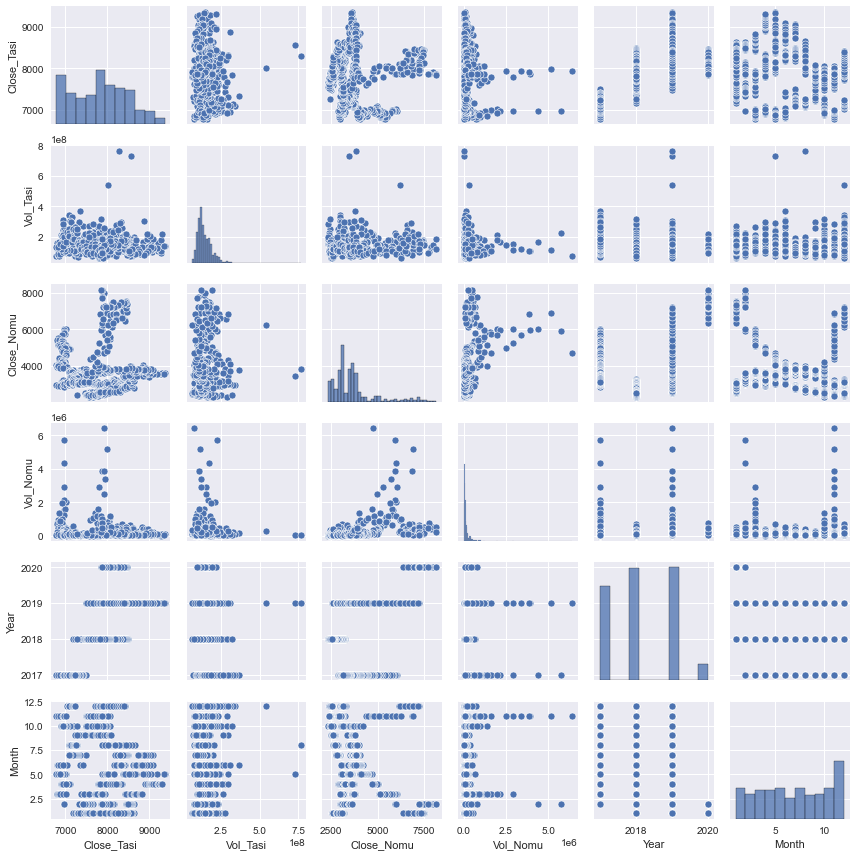

In [149]:
g=sns.pairplot(train_data.drop(columns=["Close_Sabic","Open_Sabic","High_Sabic","Low_Sabic"
                                      ,"Change%_Sabic","Vol_Sabic","Date","Day"
                                      ,"Open_Tasi","Low_Tasi","High_Tasi","Change%_Tasi"
                                      ,"Open_Nomu","Low_Nomu","High_Nomu","Change%_Nomu"]),size=2,height=1.5);
# plt.savefig('The correlation between Tasi and Nomu1.png')
plt.tight_layout()

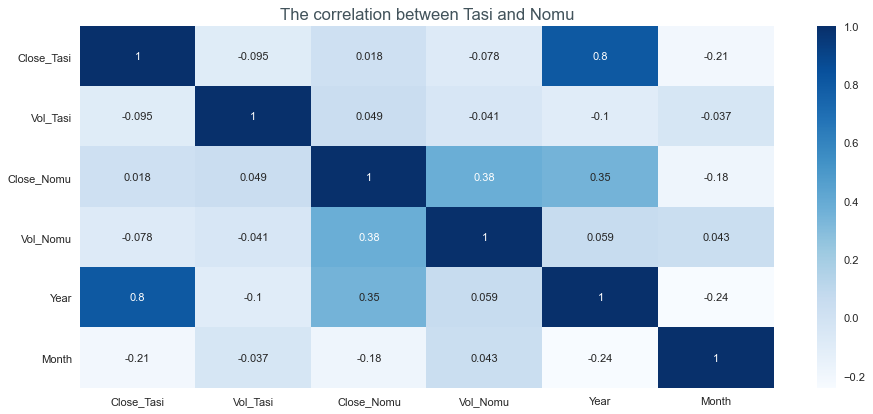

In [82]:
plt.figure(figsize=(14,6), dpi=80)
sns.heatmap(train_data.drop(columns=["Close_Sabic","Open_Sabic","High_Sabic","Low_Sabic"
                                      ,"Change%_Sabic","Vol_Sabic","Date","Day"
                                      ,"Open_Tasi","Low_Tasi","High_Tasi","Change%_Tasi"
                                      ,"Open_Nomu","Low_Nomu","High_Nomu","Change%_Nomu"]).corr(),annot=True, cmap='Blues');
plt.title("The correlation between Tasi and Nomu",size=15, color=colors['grey'] )

# plt.savefig('The correlation between Tasi and Nomu2.png',bbox_inches="tight")

# Preprocessing and Modeling

## 1. Linear Regression

In [28]:
# data preparation
x_train_lr = train_data.drop(columns=["Close_Sabic","Open_Sabic","High_Sabic","Low_Sabic"
                                      ,"Change%_Sabic","Vol_Sabic","Date","Day"
                                      ,"Open_Tasi","Low_Tasi","High_Tasi","Change%_Tasi"
                                      ,"Open_Nomu","Low_Nomu","High_Nomu","Change%_Nomu"])
y_train_lr = train_data["Close_Sabic"]

x_test_lr = test_data.drop(columns=["Close_Sabic","Open_Sabic","High_Sabic","Low_Sabic"
                                      ,"Change%_Sabic","Vol_Sabic","Date","Day"
                                      ,"Open_Tasi","Low_Tasi","High_Tasi","Change%_Tasi"
                                      ,"Open_Nomu","Low_Nomu","High_Nomu","Change%_Nomu"])
y_test_lr = test_data["Close_Sabic"]

In [29]:
# lr model 
reg = LinearRegression()
reg.fit(x_train_lr, y_train_lr)
reg.score(x_train_lr, y_train_lr)

0.7969173159536823

In [30]:
# predection & MAE
preds = reg.predict(x_test_lr)
MAE_error_lr = mean_absolute_error(y_test_lr, preds)
print('Testing Mean Absolute Error is {}'.format(MAE_error_lr))

Testing Mean Absolute Error is 61.89450026697544


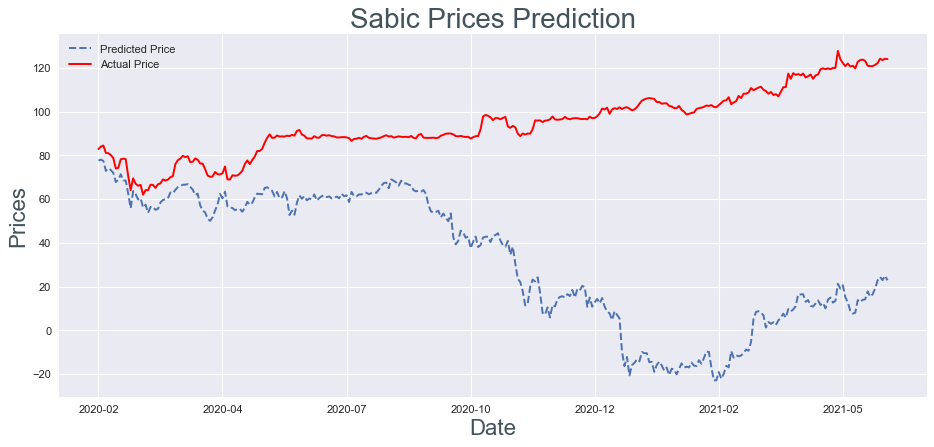

In [104]:
# visualize the predictions 

figure(figsize=(14,6), dpi=80)

plt.plot(preds,linestyle='dashed',label='Predicted Price')
plt.plot(y_test_lr.reset_index(drop=True), color='red', label='Actual Price')
plt.title('Sabic Prices Prediction',size=25, color=colors['grey'])
plt.xlabel('Date',color=colors['grey'],size=20)
plt.ylabel('Prices',color=colors['grey'],size=20)
plt.xticks(np.arange(0,len(test_data),50), test_data.Date[::50].dt.to_period('M'))
plt.legend()
# plt.savefig('Sabic Prices Prediction LR.png')
plt.show()

## 2. ARIMA Model 

## Cross-correlation for Sabic

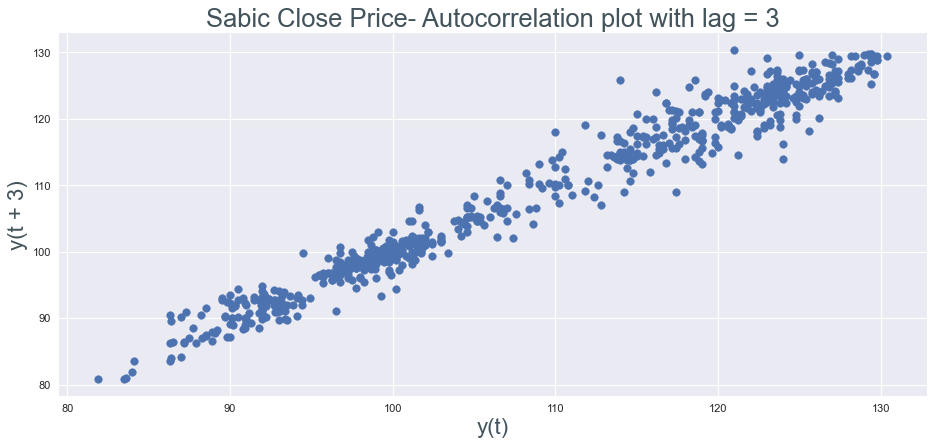

In [108]:
# checking cross-correlation
plt.figure(figsize=(14,6), dpi=80)
lag_plot(train_data['Close_Sabic'], lag=3)
plt.title('Sabic Close Price- Autocorrelation plot with lag = 3',size=23, color=colors['grey'])
plt.xlabel('y(t)',color=colors['grey'],size=20)
plt.ylabel('y(t + 3)',color=colors['grey'],size=20)
# plt.savefig('Sabic Close Price- Autocorrelation plot with lag = 3.png')
plt.show()

In [32]:
# data preparation
training_data = train_data['Close_Sabic'].values
testing_data = test_data['Close_Sabic'].values

In [33]:
# ARIMA mode & MAE calculations
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(testing_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = testing_data[time_point]
    history.append(true_test_value)
MAE_error_ARIMA = mean_absolute_error(testing_data, model_predictions)
print('Testing Mean Absolute Error is {}'.format(MAE_error_ARIMA))

Testing Mean Absolute Error is 1.0378004764596505


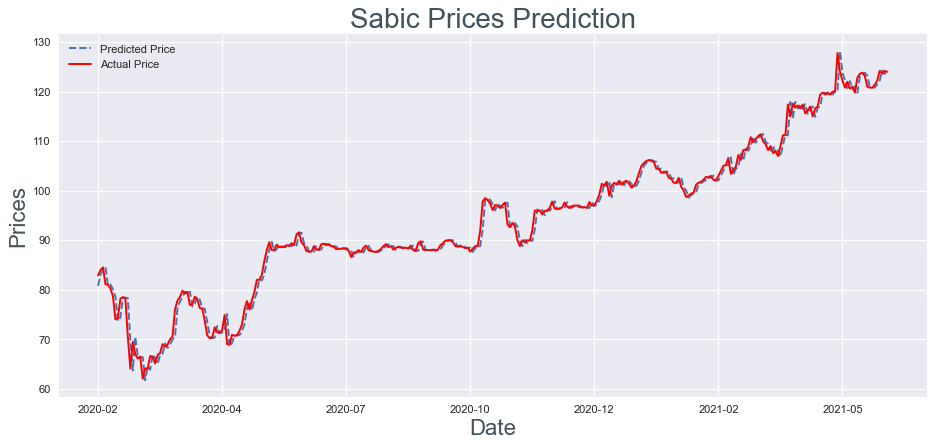

In [109]:
# visualize the predictions 

figure(figsize=(14,6), dpi=80)

#test_set_range = df[int(len(df)*0.7):].index
plt.plot( model_predictions,linestyle='dashed',label='Predicted Price')
plt.plot(testing_data, color='red', label='Actual Price')
plt.title('Sabic Prices Prediction',size=25, color=colors['grey'])
plt.xlabel('Date',color=colors['grey'],size=20)
plt.ylabel('Prices',color=colors['grey'],size=20)
plt.xticks(np.arange(0,len(test_data),50), test_data.Date[::50].dt.to_period('M'))
plt.legend()
# plt.savefig('Sabic Prices Prediction ARIMA.png')
plt.show()

## Models Comparison

In [35]:
print('Linear Regression model MAE: {} \nARIMA model MAE: {} \n '.format(MAE_error_lr,MAE_error_ARIMA))

Linear Regression model MAE: 61.89450026697544 
ARIMA model MAE: 1.0378004764596505 
 


# The forecasting model: Prophet (Future Prediction)

In [187]:
# Select only the important features i.e. the date and price
data = df[["Date","Close_Sabic"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"Date":"ds","Close_Sabic":"y"}) #renaming the columns of the dataset
data.head(5)
data.shape

(1062, 2)

In [188]:
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data); # fit the model using all data

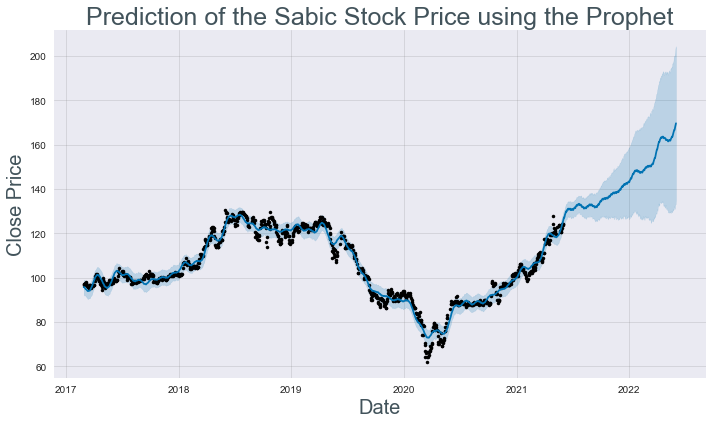

In [111]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the Sabic Stock Price using the Prophet",size=25, color=colors['grey'])
plt.xlabel("Date",color=colors['grey'],size=20)
plt.ylabel("Close Price",color=colors['grey'],size=20)
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
# plt.savefig('Prediction of the Sabic Stock Price using the Prophet.png')
plt.show()

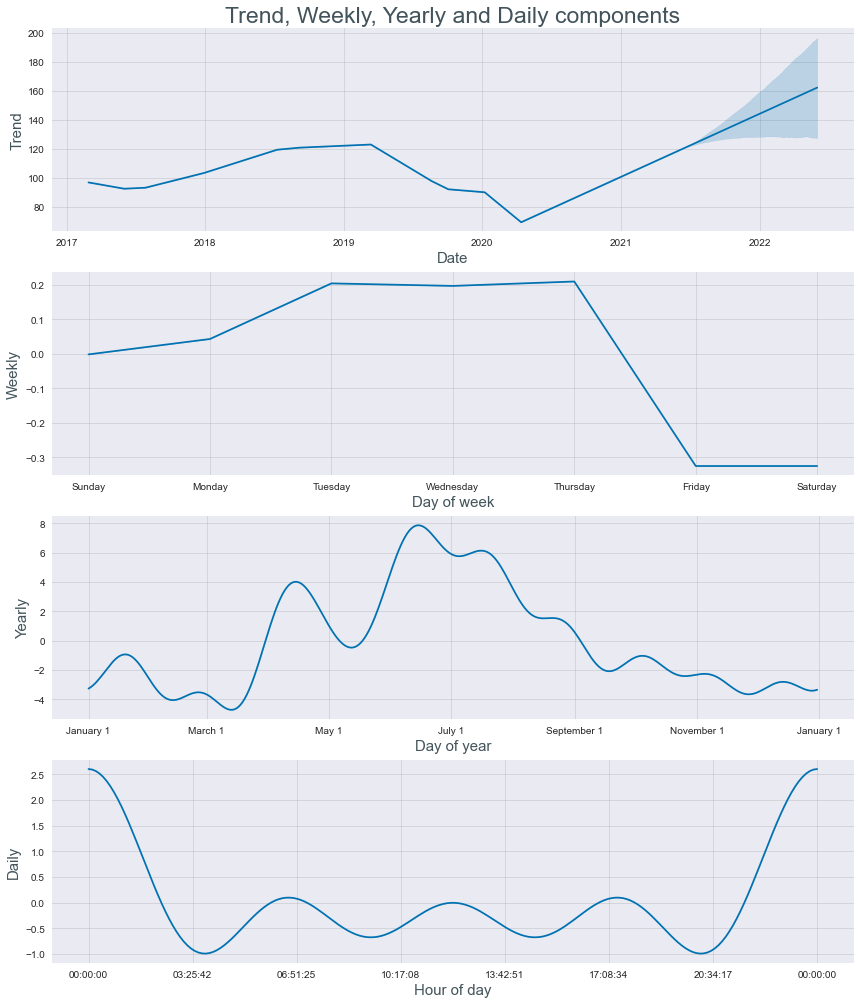

In [148]:
components_fig = m.plot_components(prediction,figsize=(12,14))
axes = components_fig.get_axes()
axes[0].set_title("Trend, Weekly, Yearly and Daily components", size=23,color=colors['grey'])
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
axes[0].set_xlabel('Date',size=15,color=colors['grey'])
axes[1].set_xlabel('Day of week',size=15,color=colors['grey'])
axes[2].set_xlabel('Day of year',size=15,color=colors['grey'])
axes[3].set_xlabel('Hour of day',size=15,color=colors['grey'])
axes[0].set_ylabel('Trend',size=15,color=colors['grey'])
axes[1].set_ylabel('Weekly',size=15,color=colors['grey'])
axes[2].set_ylabel('Yearly',size=15,color=colors['grey'])
axes[3].set_ylabel('Daily',size=15,color=colors['grey'])
# plt.savefig('Prediction of the Sabic Stock Price using the Prophet2.png')
plt.show()